# AUTO INSURANCE

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append('src')

import loading
import preprocessing
import visualization
import model
import evaluation

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

## Loading data

In [3]:
amount_col = ['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM']
path = 'data/auto-insurance-fall-2017/'

df = pd.read_csv(path + 'train_auto.csv')

for col in amount_col:
    df[col] = df[col].str[1:].str.replace(',','').astype(float)

In [4]:
df.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,67349.0,No,0.0,...,14230.0,11,Minivan,yes,4461.0,2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,91449.0,No,257252.0,...,14940.0,1,Minivan,yes,0.0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,16039.0,No,124191.0,...,4010.0,4,z_SUV,no,38690.0,2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,306251.0,...,15440.0,7,Minivan,yes,0.0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,114986.0,No,243925.0,...,18000.0,1,z_SUV,no,19217.0,2,Yes,3,17.0,Highly Urban/ Urban


## Exploratory Data Analysis

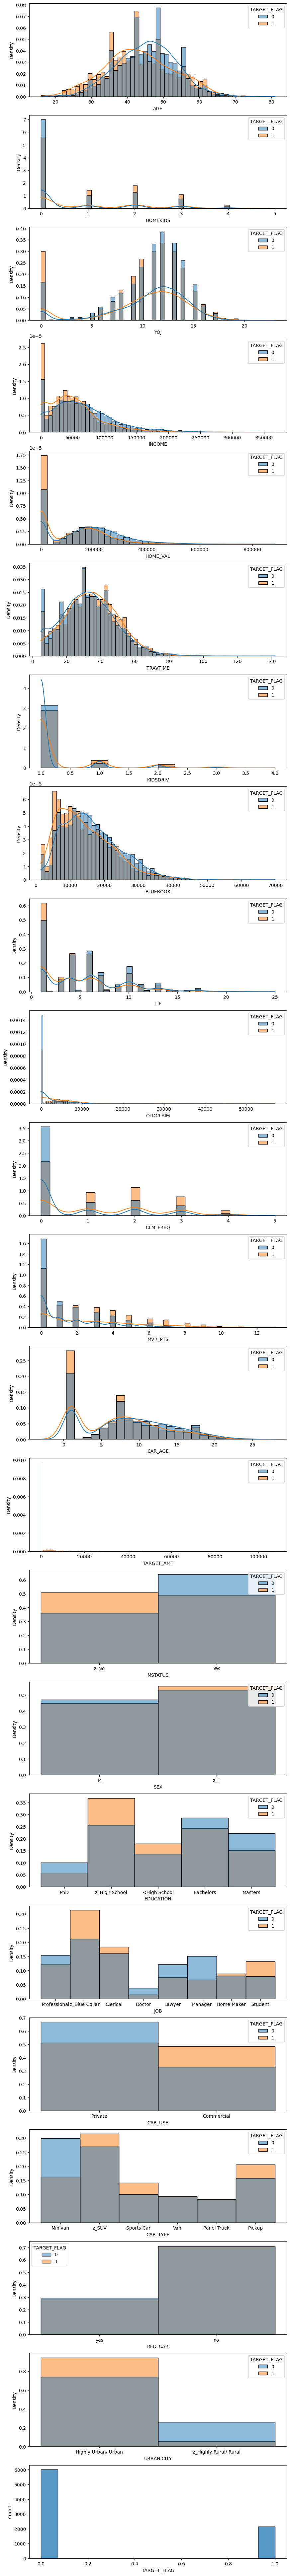

In [5]:
quant_columns = ['AGE', 'HOMEKIDS','YOJ', 'INCOME','HOME_VAL','TRAVTIME','KIDSDRIV', 'BLUEBOOK', 'TIF','OLDCLAIM', 'CLM_FREQ','MVR_PTS', 'CAR_AGE']
cat_columns = ['TARGET_AMT', 'MSTATUS', 'SEX', 'EDUCATION','JOB', 'CAR_USE', 'CAR_TYPE', 'RED_CAR', 'URBANICITY']
target = ['TARGET_FLAG']

fig, ax = plt.subplots(nrows = len(quant_columns + cat_columns) + 1,figsize = (10,100))
    
for (i,col) in enumerate(quant_columns + cat_columns):
    sns.histplot(df, x = col, hue = 'TARGET_FLAG', ax = ax[i], kde = (col in quant_columns),common_norm=False, stat='density')
    
sns.histplot(df,x = 'TARGET_FLAG', ax = ax[-1])
plt.show()

By plotting graphs conditionning on target, we can deduce the role of the features in differentiating the different target classes. Target classes are imbalanced, so the metric and optimization losses should be taking that into account.

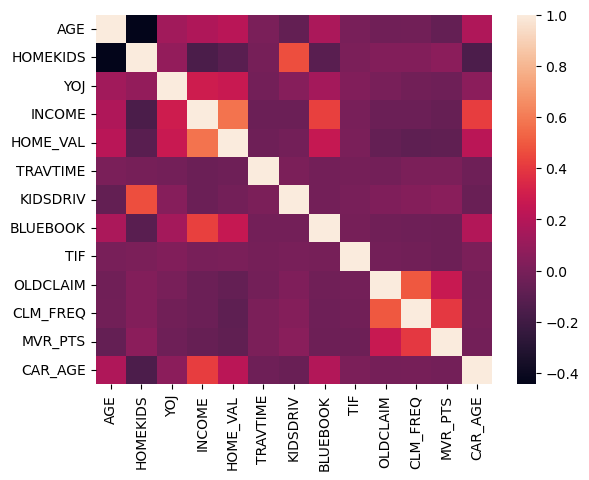

In [6]:
sns.heatmap(df[quant_columns].corr())
plt.show()

AGE and HOMEKIDS are significatively negatively correlated, wherease OLD CLAIM, CLAIM FREQUENCY and MVR POINTS are significatively positively correlated. We will thus only select some of them to have decorrelated columns.

## Preprocessing

In [7]:
# Feature engineering

df['HIGHSCHOOL'] = df.EDUCATION.isin(['Bachelors','Masters','PhD'])
df['HIGHSPC'] = df.JOB.isin(['Doctor','Lawyer','Manager'])

quant_features = ['AGE', 'INCOME','TRAVTIME','KIDSDRIV', 'BLUEBOOK', 'TIF','CLM_FREQ','CAR_AGE']
cat_features = ['MSTATUS', 'SEX', 'HIGHSCHOOL','HIGHSPC', 'CAR_USE', 'CAR_TYPE', 'RED_CAR', 'URBANICITY']
features = quant_features + cat_features

In [8]:
# Train/Test split

X_train, X_val, y_train, y_val = train_test_split(df[features],df[target],train_size = 0.7, stratify = df[target])

In [9]:
# We one hot encode categorical features and scale numerical features

preprocessor = ColumnTransformer([("quant",StandardScaler(),quant_features),
                                    ("cat",OneHotEncoder(sparse = False,drop = 'first'),cat_features)],
                                    remainder = 'drop')

preprocessor.fit(X_train)

X_train_preprocess = np.nan_to_num(preprocessor.transform(X_train),0)
X_val_preprocess = np.nan_to_num(preprocessor.transform(X_val),0)

y_train = y_train.values.ravel()
y_val = y_val.values.ravel()

features_preprocess = preprocessor.get_feature_names_out(X_train.columns)

p = len(features_preprocess)

## Model selection

Remark : as class are imbalanced, accuracy is not the best metric to evaluate the performance. We will thus prefer to use f1-score. Models are adjusted to compute reweighted losses. Also, we weight losses according to the classes to have balance predictions.

In [28]:
## Logistic Regression

from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(class_weight = 'balanced')
logistic_params = {'C' : [0.01,0.1,1]}

grid_search_logistic = GridSearchCV(logistic_regression, param_grid=logistic_params, n_jobs=-1,scoring = 'f1')
clf_logistic = grid_search_logistic.fit(X_train_preprocess, y_train)

print(clf_logistic.best_score_)

0.5711061073411435


In [29]:
## Decision Tree

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(class_weight = 'balanced')
tree_params = {'ccp_alpha' : [0,0.1,1]}

grid_search_tree = GridSearchCV(tree, param_grid=tree_params, n_jobs=-1,scoring = 'f1')
clf_tree = grid_search_tree.fit(X_train_preprocess, y_train)

print(clf_tree.best_score_)

0.4175090821457603


In [30]:
## Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight = 'balanced')
rf_params = {'ccp_alpha' : [0,0.1,1]}

grid_search_rf = GridSearchCV(rf, param_grid=rf_params, n_jobs=-1,scoring = 'f1')
clf_rf = grid_search_rf.fit(X_train_preprocess, y_train)

print(clf_rf.best_score_)

0.39413033819608245


In [31]:
## Gradient Boosting

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators = 200,subsample = 0.5, max_features = 'sqrt')
gb_params = {'max_depth' : [3,4,5]}

grid_search_gb = GridSearchCV(gb, param_grid=gb_params, n_jobs=-1,scoring = 'f1')
clf_gb = grid_search_gb.fit(X_train_preprocess, y_train)

print(clf_gb.best_score_)

0.4890095850517948


## Interpretability

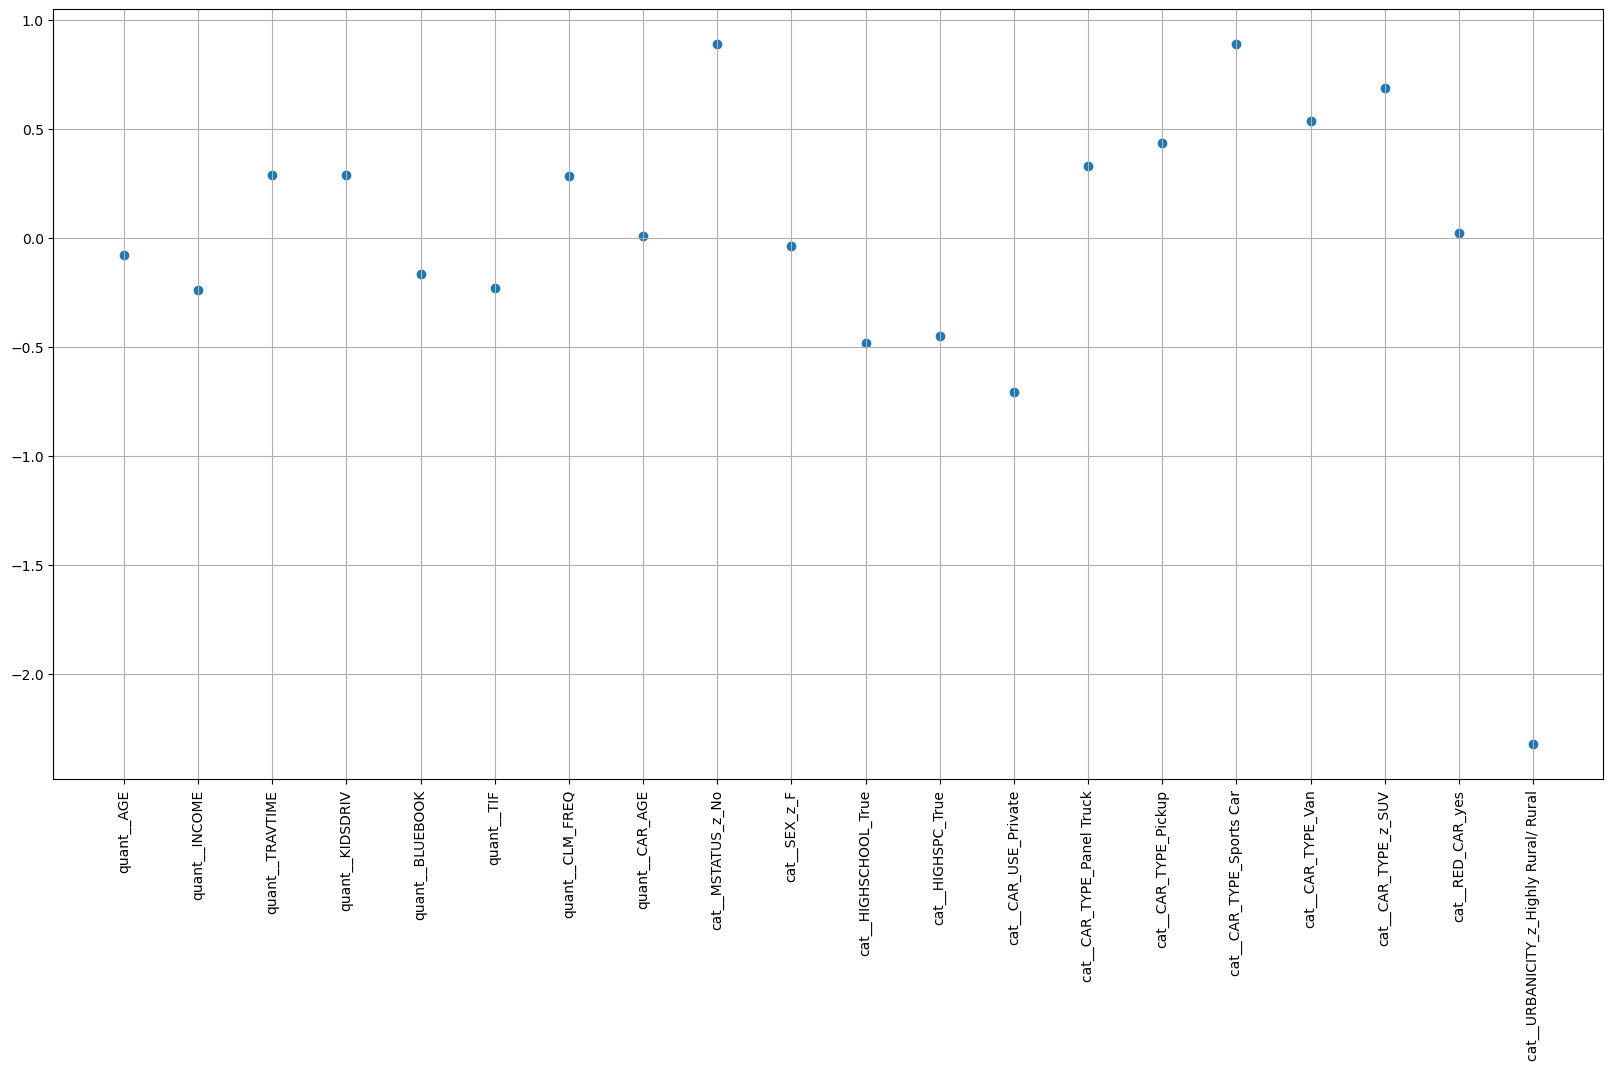

In [32]:
## Linear Regression

plt.figure(figsize = (20,10))
plt.scatter(range(p),clf_logistic.best_estimator_.coef_)
plt.grid(True)
plt.xticks(range(p),features_preprocess,rotation = 90)
plt.show()

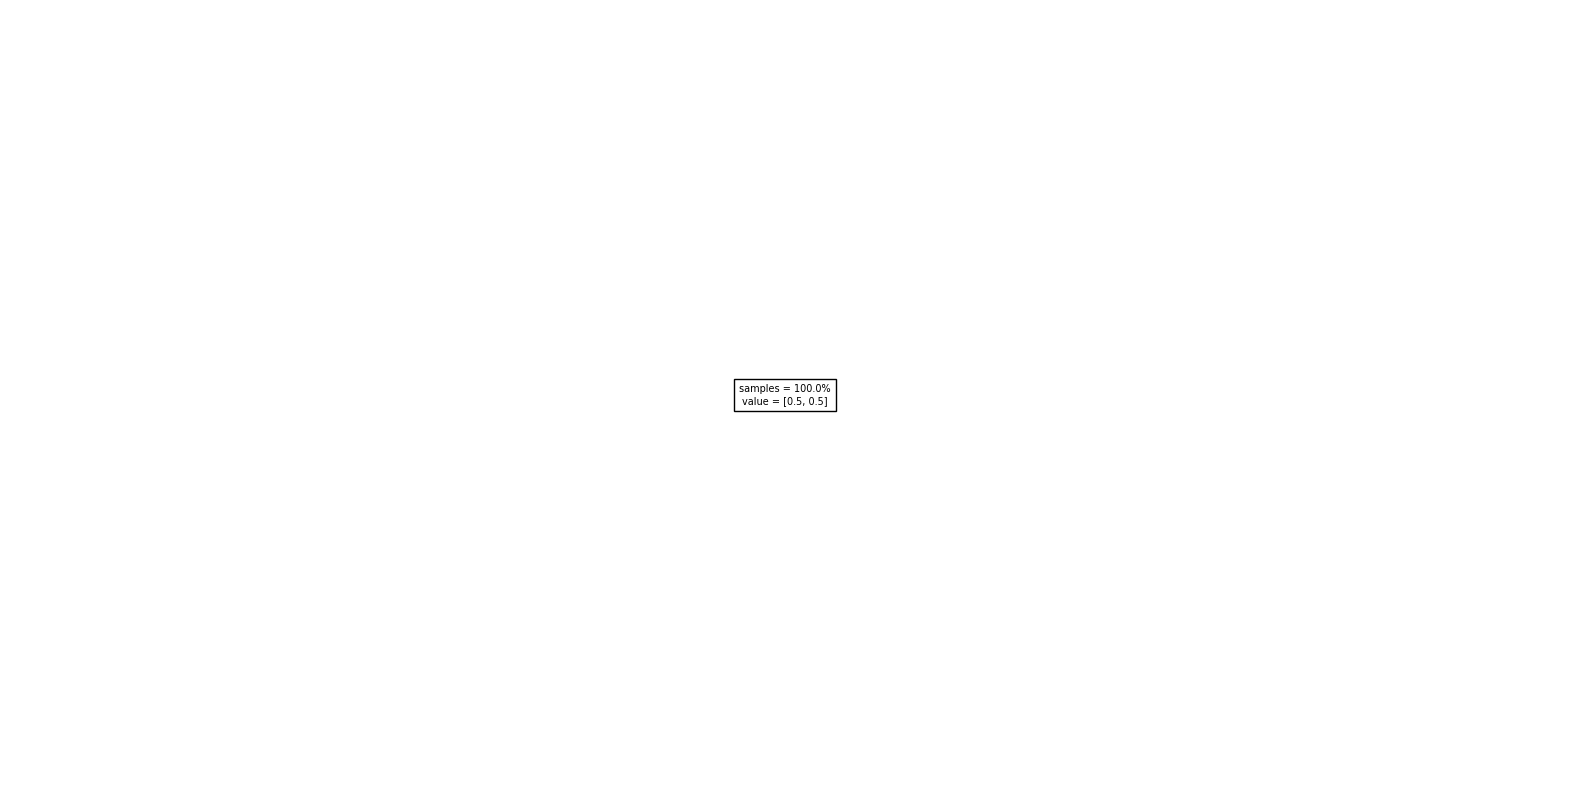

In [33]:
## Decision Tree

from sklearn.tree import plot_tree

plt.figure(figsize = (20,10))
plot_tree(clf_tree.best_estimator_,feature_names=features_preprocess,filled = True,proportion = True,max_depth = 3,fontsize = 7,impurity = False)
plt.show()

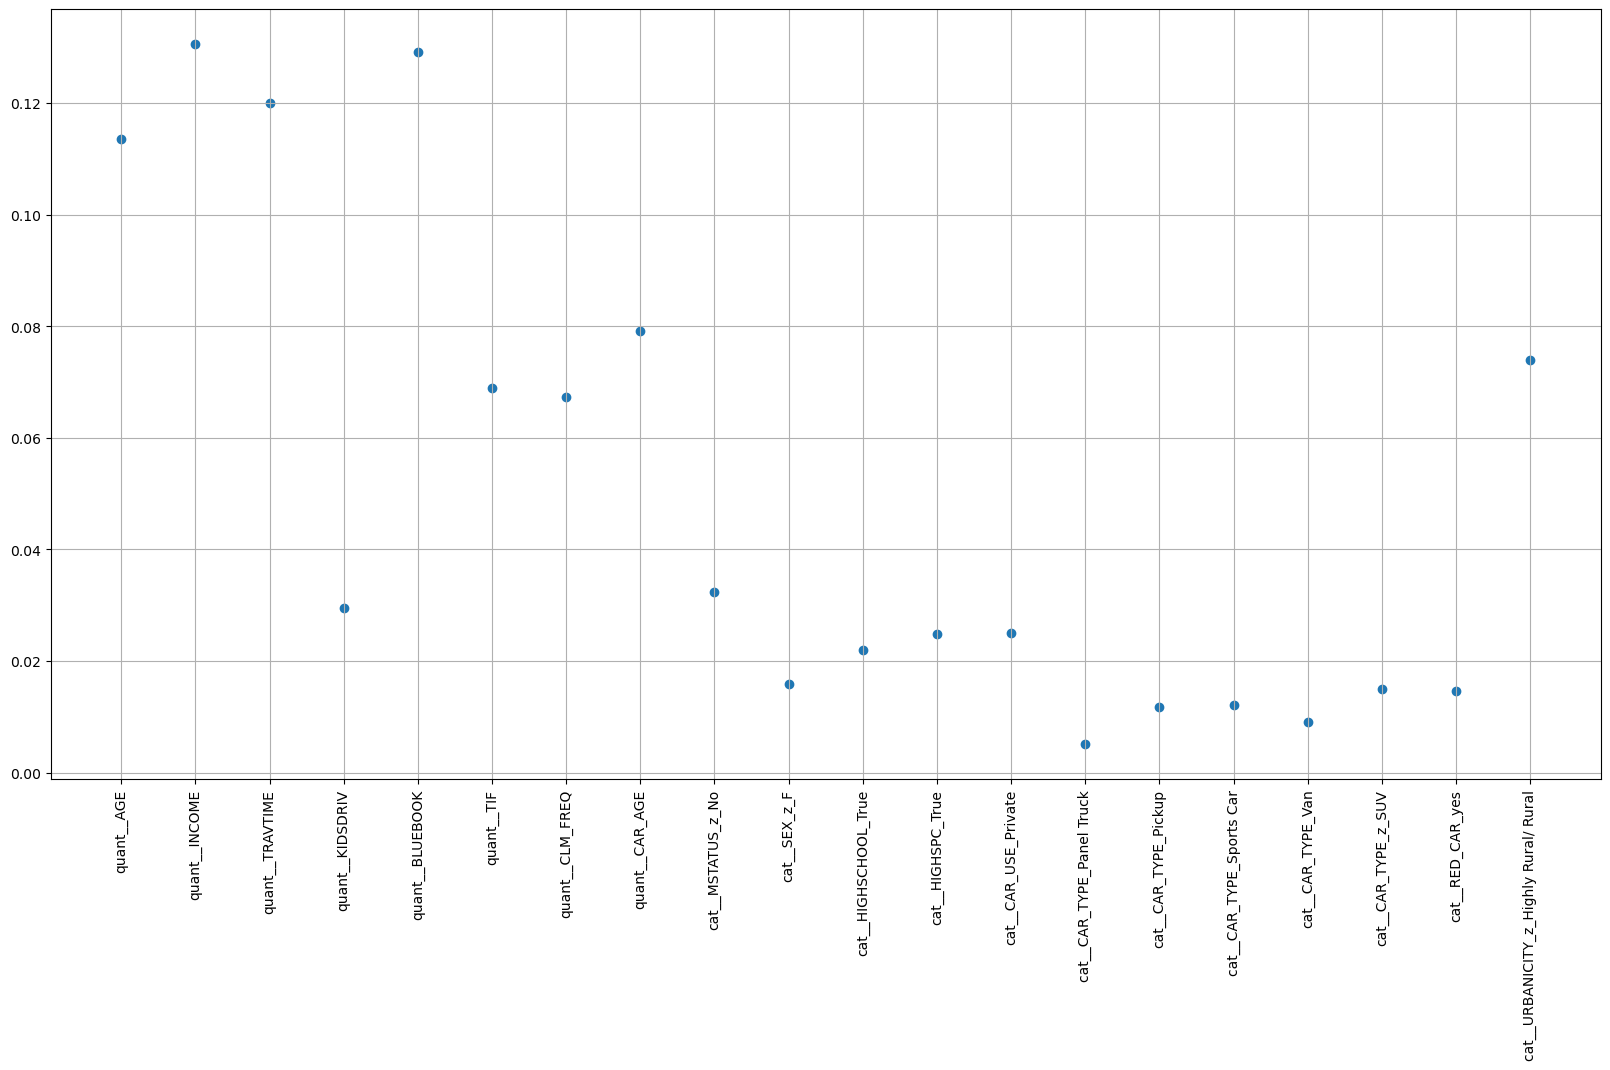

In [35]:
## Random Forest

plt.figure(figsize = (20,10))
plt.scatter(range(p),clf_rf.best_estimator_.feature_importances_)
plt.xticks(range(p),features_preprocess,rotation = 90)
plt.grid(True)
plt.show()

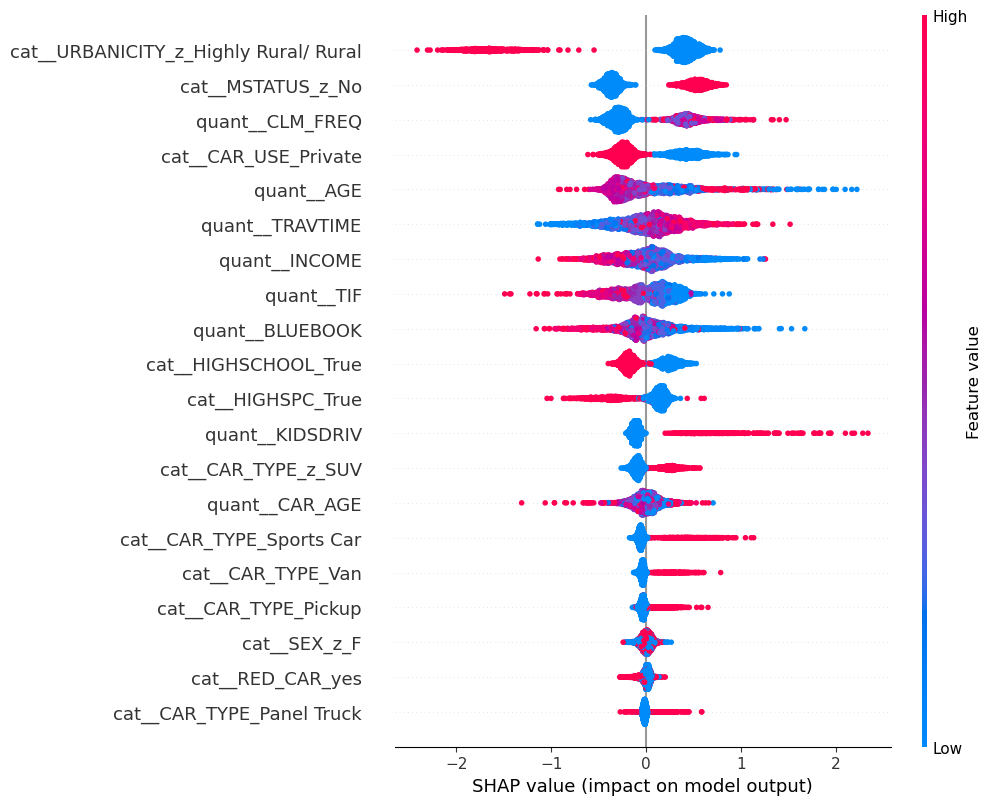

In [36]:
## Gradient Boosting
import shap

explainer_shap = shap.TreeExplainer(clf_gb.best_estimator_)
shap_values = explainer_shap.shap_values(X_val_preprocess)
shap.summary_plot(shap_values, X_val_preprocess,feature_names = features_preprocess)

In [37]:
@interact

def force_plot(index = (0,len(X_val)-1,1)):
    shap.initjs()
    return shap.force_plot(explainer_shap.expected_value, shap_values[index,:], X_val_preprocess[index],feature_names = features_preprocess)

interactive(children=(IntSlider(value=1224, description='index', max=2448), Output()), _dom_classes=('widget-i…

## Evaluation

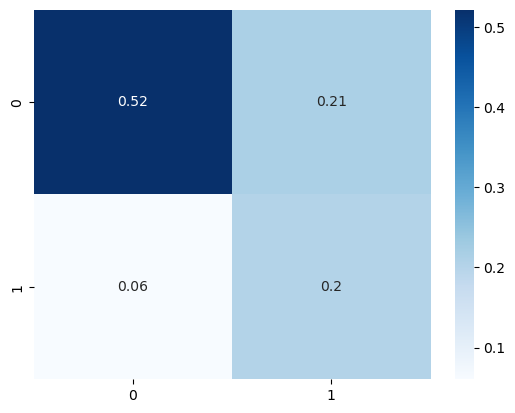

In [48]:
from sklearn.metrics import confusion_matrix 

y_pred = clf_logistic.best_estimator_.predict(X_val_preprocess)
sns.heatmap(confusion_matrix(y_val,y_pred,normalize = 'all'),annot = True,cmap = plt.cm.Blues)
plt.show()